<a href="https://colab.research.google.com/github/soumyajoykundu/Applied-Machine-Learning-2025/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **AML Assignment 01 : Prototype**
#### **Task : Build a prototype for sms spam classification**


- Name: Soumyajoy Kundu
- Roll No: MDS202349

----

* in `train.ipynb` write the functions to
    * fit a model on train data
    * score a model on given data
    * evaluate the model predictions
    * validate the model
        * fit on train
        * score on train and validation
        * evaluate on train and validation
        * fine-tune hyper-params using train and validation (if necessary)
    * score three benchmark models on test data and select the best one



*Notes*:
* You may download sms spam data from https://archive.ics.uci.edu/ml/datasets/sms+spam+collection
* You may refer to https://radimrehurek.com/data_science_python/ for building a prototype

----

### Importing Libraries

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [55]:
def load_split_data(train_path='/content/train.csv', validation_path='/content/validation.csv', test_path = '/content/test.csv'):
    """
    Load training and validation data from CSV files.
    Args:
        train_path (str): Path to the training data file.
        validation_path (str): Path to the validation data file.
    Returns:
        pd.DataFrame, pd.DataFrame: Training and validation datasets.
    """
    train_data = pd.read_csv(train_path)
    validation_data = pd.read_csv(validation_path)
    test_data = pd.read_csv(test_path)

    return train_data, validation_data, test_data

In [3]:
train_data, validation_data, test_data = load_split_data()

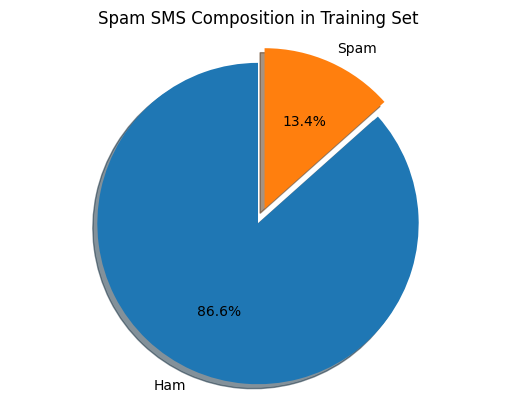

In [64]:
# Count the occurrences of 'ham' and 'spam'
ham_count = train_data['Label'].value_counts()[0]
spam_count = train_data['Label'].value_counts()[1]

# Create the pie chart
labels = ['Ham', 'Spam']
sizes = [ham_count, spam_count]
explode = (0.1, 0)

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Spam SMS Composition in Training Set')
plt.show()

* Due to correct splitting of data, the imbalance characteristic is also evident in the training set.
* To address this imbalance, we have taken the following step,
    * **Using Class Weights**: Incorporate the `class_weight` parameter in the models, while training.
        * **Balances class impact**: Gives more importance to the minority class during training.
        * **Improves metrics**: Enhances Precision, Recall, and F1 Score for the minority class.
        * **Avoids resampling**: No data duplication or removal, preserving dataset integrity.

* vectorizing the text messages into a sparse matrix of token counts using `CountVectorizer` and prepares labels for training.

In [5]:
# Vectorize the text messages
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_data['Message'])
y_train = train_data['Label']

X_valid = vectorizer.transform(validation_data['Message'])
y_valid = validation_data['Label']

X_test = vectorizer.transform(test_data['Message'])
y_test = test_data['Label']

### Fitting a baseline model


* Fit a model `MultiomialNB()`(Naive Bayes Classifier) on Training Data

In [ ]:
# Fitting the Naive Bayes model on the train data
model = MultinomialNB()
model.fit(X_train, y_train)
model

MultinomialNB()


* Let's predict on validation set (unseen data)

In [ ]:
# Model predictions on the validation set
y_pred = model.predict(X_valid)

* Evaluating the predictions based on scores like,
  - `Precision` : The proportion of messages predicted as spam that are actually spam.
  - `Recall` : The proportion of actual spam messages that are correctly identified as spam.
  - `F1-Score` : The harmonic mean of precision and recall, balancing their trade-off.
  - `ROC-AUC score` : Measures the model's ability to distinguish between spam and ham messages, with higher values indicating better discrimination.

In [ ]:
# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()

# Compute evaluation metrics manually
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + fp + fn + tn)

# Print the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_valid, y_pred)
print(f"ROC-AUC Score: {roc_auc:.4f}")

Precision: 0.9643
Recall: 0.9000
F1-Score: 0.9310
Accuracy: 0.9821
ROC-AUC Score: 0.9474


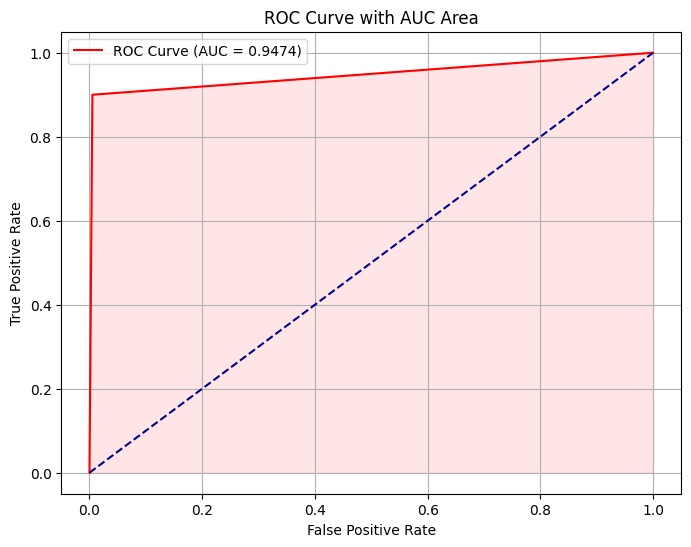

In [ ]:
# Plot the ROC curve with shaded area
fpr, tpr, thresholds = roc_curve(y_valid, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.fill_between(fpr, tpr, alpha=0.1, color='red')  # Shaded area
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.title('ROC Curve with AUC Area')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

### Functions to train and fine-tune the benchmark models

#### Fit on train


In [6]:
def train_model(model, X_train, y_train):
    """
    Train the model on the training set, accounting for class imbalance.
    """
    # Check if the model supports class_weight
    if hasattr(model, "class_weight"):
        model.set_params(class_weight="balanced")
    model.fit(X_train, y_train)
    return model

#### Defining Appropriate Score Metric
* `Accuracy` is not a good metric for imbalanced datasets because it can be misleading, as the model may predict only the majority class and still achieve a high accuracy.

* Evaluating the predictions based on scores like,
  - `Precision` : The proportion of messages predicted as spam that are actually spam.
  - `Recall` : The proportion of actual spam messages that are correctly identified as spam.
  - `F1-Score` : The harmonic mean of precision and recall, balancing their trade-off.
  - `ROC-AUC score` : Measures the model's ability to distinguish between spam and ham messages, with higher values indicating better discrimination.

* **Higher Precision**: Ensures that spam SMS are correctly identified with fewer false positives, but some spam may be missed and appear in the normal inbox, where they can be deleted manually.

* **Higher Recall**: Focuses on capturing most spam messages, even if it means marking some legitimate messages as spam, which can then be reviewed in the spam folder, but that's often not the case because we never frequently check the spam folder and a very important sms if get's  marked as spam is a serious loss.

* **F-score** is considered in fine-tuning the models to balance Precision and Recall, ensuring optimal performance for imbalanced datasets as it is in this context.

#### Fine-Tune on Validation Set

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

def tune_model(model, param_grid, X_train, y_train):
    """
    Fine-tune the model using GridSearchCV with weighted scoring for the imbalanced dataset.
    """
    # Add class_weight to the param grid if the model supports it
    if hasattr(model, "class_weight") and "class_weight" not in param_grid:
        param_grid["class_weight"] = ["balanced"]

    # Use F1 weighted scoring
    grid_search = GridSearchCV(model, param_grid, scoring='f1_weighted', cv=5)
    grid_search.fit(X_train, y_train)

    print("Best Parameters:", grid_search.best_params_)
    print(f"Best F1 Weighted Score: {round(grid_search.best_score_, 4)}\n")

    return grid_search.best_estimator_

#### Evaluating on Test Set

In [8]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the final model on the test set.
    """
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1_score_val = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc_val = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) if hasattr(model, 'predict_proba') else 0



    return {
        "Precision": round(precision,4),
        "Recall": round(recall,4),
        "F1-Score": round(f1_score_val,4),
        "Accuracy": round(accuracy,4),
        "ROC-AUC": round(roc_auc_val,4)
    }

#### Learning Curve

In [9]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, model_name):
    train_sizes, train_scores, valid_scores = learning_curve(
        model, X, y, cv=5, scoring='f1', train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_mean = train_scores.mean(axis=1)
    valid_mean = valid_scores.mean(axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label='Training F1 Score')
    plt.plot(train_sizes, valid_mean, label='Validation F1 Score')
    plt.title(f'Learning Curve for {model_name}')
    plt.xlabel('Training Size')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Confusion Matrix

In [10]:
def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    """
    Plots a confusion matrix with annotations.

    Args:
        y_true (array-like): Ground truth (true labels).
        y_pred (array-like): Predicted labels.
        labels (list): List of label names for the axes.
        title (str): Title of the plot.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title, fontsize=14)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.tight_layout()
    plt.show()

#### AUC-ROC Curve

In [11]:
def plot_roc_auc_curve(y_true, y_proba, title="ROC-AUC Curve"):
    """
    Plots the ROC-AUC curve for a binary classification model.

    Args:
        y_true (array-like): Ground truth (true binary labels).
        y_proba (array-like): Predicted probabilities for the positive class.
        title (str): Title of the plot.
    """

     # Plot the ROC curve with shaded area
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)
    print(f"ROC-AUC Score: {round(roc_auc,4)}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='red', label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.fill_between(fpr, tpr, alpha=0.1, color='red')  # Shaded area
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

* Defining a data frame to store all the evaluation metrics of the models to compare them.

In [12]:
models_df = pd.DataFrame()

In [22]:
import warnings
warnings.filterwarnings('ignore')

### Results - 3 Benchmark Models
- Naive Bayes Classifier
- Logistic Regression
- Random Forest Classifier

#### Naive Bayes Classifier

In [13]:
NB_model = MultinomialNB()
NB_model = train_model(NB_model, X_train, y_train)

In [14]:
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    'fit_prior': [True, False]
}

NB_best = tune_model(NB_model, param_grid, X_valid, y_valid)
NB_best

Best Parameters: {'alpha': 0.1, 'fit_prior': True}
Best F1 Weighted Score: 0.9711



MultinomialNB(alpha=0.1)

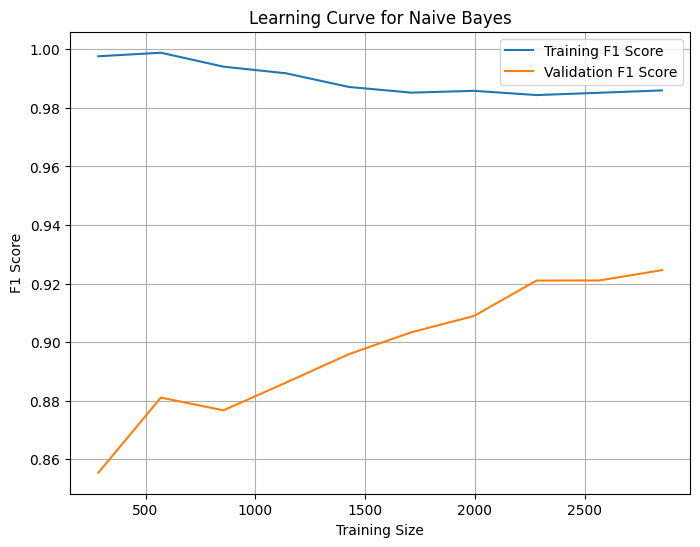

In [15]:
plot_learning_curve(NB_best, X_train, y_train, 'Naive Bayes')

In [16]:
NB_best_eval = evaluate_model(NB_best, X_test, y_test)
NB_best_eval

{'Precision': 0.9195,
 'Recall': 0.9195,
 'F1-Score': 0.9195,
 'Accuracy': 0.9785,
 'ROC-AUC': 0.9815}

In [17]:
models_df['Naive Bayes'] = NB_best_eval

In [18]:
NB_best_predictions = NB_best.predict(X_test)

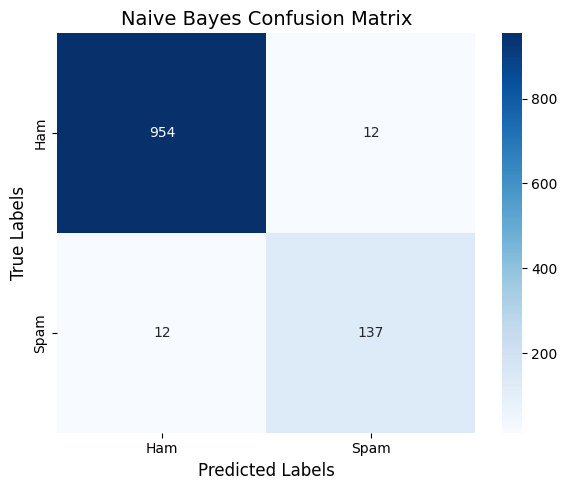

In [19]:
plot_confusion_matrix(y_test, NB_best_predictions, labels=['Ham', 'Spam'], title='Naive Bayes Confusion Matrix')

In [20]:
NB_best_predict_prob = NB_best.predict_proba(X_test)[:, 1]

ROC-AUC Score: 0.9815


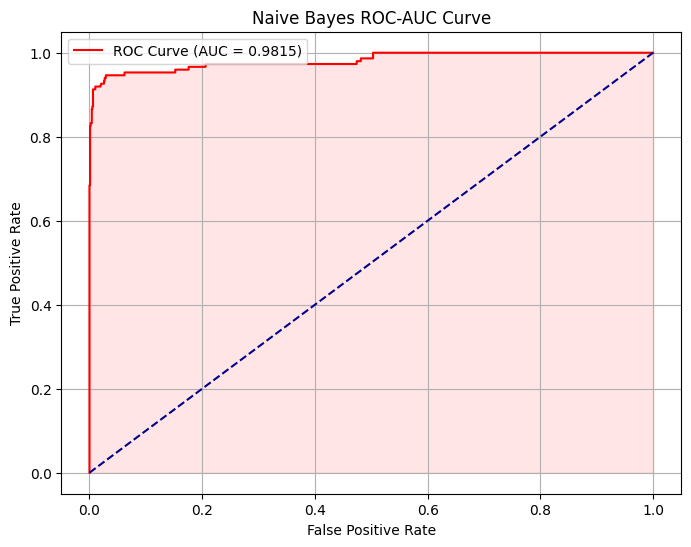

In [21]:
plot_roc_auc_curve(y_test, NB_best_predict_prob, title='Naive Bayes ROC-AUC Curve')

#### Logistic Regression

In [23]:
LR_model = LogisticRegression()
LR_model = train_model(LR_model, X_train, y_train)

In [24]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

LR_best = tune_model(LR_model, param_grid, X_valid, y_valid)
LR_best

Best Parameters: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Best F1 Weighted Score: 0.9772



LogisticRegression(C=1, class_weight='balanced', solver='liblinear')

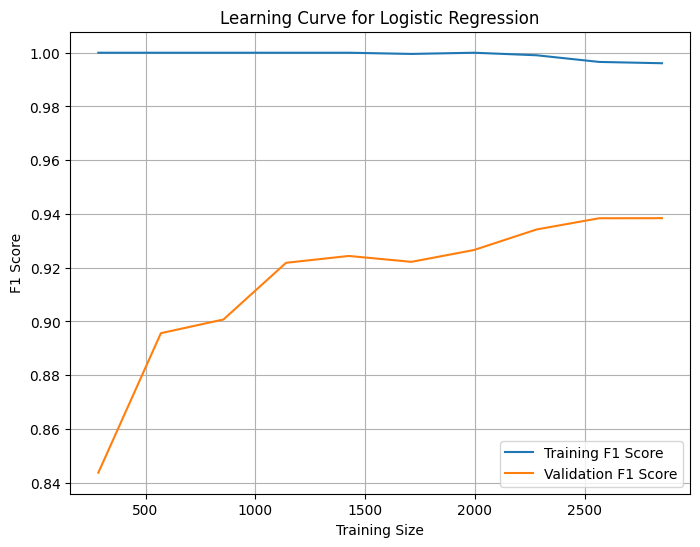

In [26]:
plot_learning_curve(LR_best, X_train, y_train, 'Logistic Regression')

In [25]:
LR_best_eval = evaluate_model(LR_best, X_test, y_test)
LR_best_eval

{'Precision': 0.9839,
 'Recall': 0.8188,
 'F1-Score': 0.8938,
 'Accuracy': 0.974,
 'ROC-AUC': 0.9852}

In [27]:
models_df['Logistic Regression'] = LR_best_eval

In [28]:
LR_best_predictions = LR_best.predict(X_test)

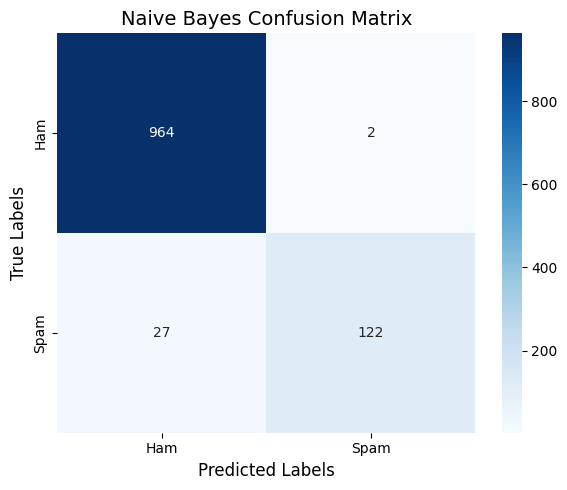

In [29]:
plot_confusion_matrix(y_test, LR_best_predictions, labels=['Ham', 'Spam'], title='Naive Bayes Confusion Matrix')

In [30]:
LR_best_predict_prob = LR_best.predict_proba(X_test)[:, 1]

ROC-AUC Score: 0.9852


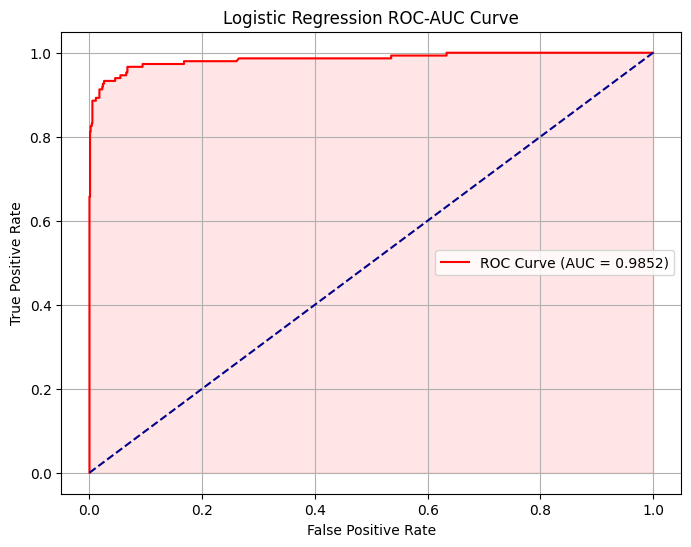

In [31]:
plot_roc_auc_curve(y_test, LR_best_predict_prob, title='Logistic Regression ROC-AUC Curve')

#### Random Forest Classifier

In [32]:
RF_model = RandomForestClassifier()
RF_model = train_model(RF_model, X_train, y_train)

In [42]:
param_grid = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_depth': [None, 10,20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

RF_best = tune_model(RF_model, param_grid, X_valid, y_valid)
RF_best

Best Parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
Best F1 Weighted Score: 0.9752



RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=500)

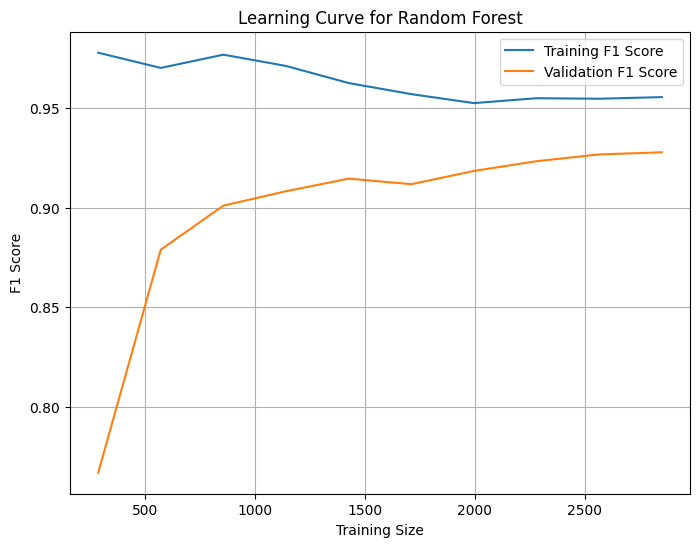

In [43]:
plot_learning_curve(RF_best, X_train, y_train, 'Random Forest')

In [44]:
RF_best_eval = evaluate_model(RF_best, X_test, y_test)
RF_best_eval

{'Precision': 0.9828,
 'Recall': 0.7651,
 'F1-Score': 0.8604,
 'Accuracy': 0.9668,
 'ROC-AUC': 0.9861}

In [45]:
models_df['Random Forest'] = RF_best_eval

In [46]:
RF_best_predictions = RF_best.predict(X_test)

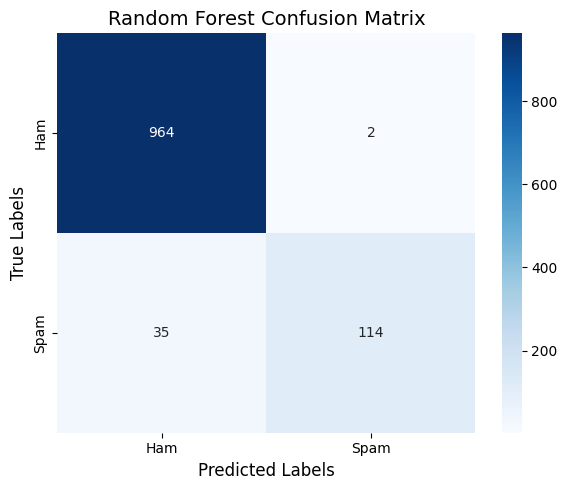

In [47]:
plot_confusion_matrix(y_test, RF_best_predictions, labels=['Ham', 'Spam'], title='Random Forest Confusion Matrix')

In [48]:
RF_best_predict_prob = RF_best.predict_proba(X_test)[:, 1]

ROC-AUC Score: 0.9861


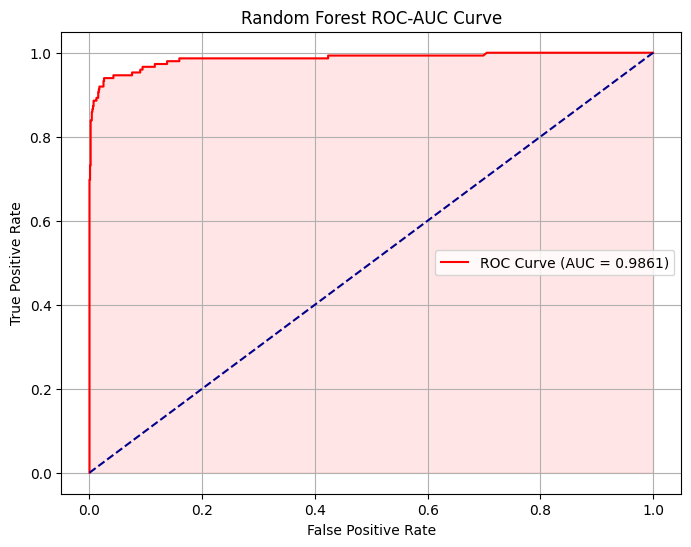

In [49]:
plot_roc_auc_curve(y_test, RF_best_predict_prob, title='Random Forest ROC-AUC Curve')

### Comparison of Benchmark Models

In [50]:
models_df

,Naive Bayes,Logistic Regression,Random Forest
Precision,0.9195,0.9839,0.9828
Recall,0.9195,0.8188,0.7651
F1-Score,0.9195,0.8938,0.8604
Accuracy,0.9785,0.9740,0.9668
ROC-AUC,0.9815,0.9852,0.9861


**Which model is best?**

* `Logistic Regression` is the best choice for spam classification after using the weighted model.
* It has high Precision (0.9839) and better Recall (0.8188) compared to Random Forest, which ensures fewer false positives while maintaining a reasonable ability to capture spam messages.
* While Naive Bayes has a higher F1-Score, its Precision (0.9195) is significantly lower, making it less suitable when Precision is the key metric.
* Logistic Regression strikes the right balance between Precision and Recall, making it ideal for this task.
* Easily interpretable model, which is also beneficial for understanding decision-making and ensuring trust in predictions.

In [65]:
best_model = LR_best
best_model

LogisticRegression(C=1, class_weight='balanced', solver='liblinear')

In [68]:
example_messages = [
    "Congratulations! You've won a $1000 gift card. Click here to claim your prize now.",
    "Hi, are we still meeting tomorrow for coffee?",
]

example_vectors = vectorizer.transform(example_messages)

# Predict spam or not spam
predictions = best_model.predict(example_vectors)

# Predict probabilities for each class (if available)
probabilities = best_model.predict_proba(example_vectors)

In [69]:
for i, message in enumerate(example_messages):
    print(f"Message: {message}")
    print(f"Prediction: {'Spam' if predictions[i] == 1 else 'Not Spam'}")
    print(f"Spam Probability: {probabilities[i][1]:.2f}\n")

Message: Congratulations! You've won a $1000 gift card. Click here to claim your prize now.
Prediction: Spam
Spam Probability: 0.89

Message: Hi, are we still meeting tomorrow for coffee?
Prediction: Not Spam
Spam Probability: 0.07

